### Preliminaries

We will be using the data shown in class on house sales in Ames, Iowa.  Data documentation can be found at http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

The code block below loads the data (much as done in class) and removes a few problematic rows and columns before converting it into a `numpy` matrix, `X`.  **Do NOT adjust** this code.  Further, you **may not add additional imports** to this notebook.

For ordinal or numeric values, they are kept as in the original data.  Categorical values are converted to consecutive integers, starting with 0.  When complete, the following variables have been added to the workspace:
 - `X`: the data, of shape (number of homes, number of features).  The last feature is the one of interest for prediction: the sale price
 - `featurenames`: an array (of strings) of each of the features'/columns' names
 - `iscat`: an array (of length `nfeat`) of booleans; True indicates the feature is categorical.
 - `categorynames`: an array of arrays of strings.  `categorynames[j][k]` is the name of the kth category for the jth feature/column (assuming that `iscat[j]` is True, otherwise `categorynames[j]` should be ignored).
 - `numcat`: an array of ints.  `numcat[j]` is the number of categories (same as `len(categorynames[j])`) for feature/column j
 - `nfeat`: total number of features/columns (including the value to be predicted -- the last feature)
 - `ncat`: number of categorical features/columns
 - `nreal`: number of numeric features/columns

In [79]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 150 # this and above will make the figures large enough to read
def loadamesdata():
    import pandas as pd
    
    dataframe = pd.read_table('AmesHousing.txt',delimiter='\t')

    dataframe = dataframe[dataframe['Gr Liv Area']<4000] # remove the five really large houses
    dataframe = dataframe[dataframe['Sale Condition']=='Normal'] # don't consider partial sales or other types of abnormal sales
    dataframe = dataframe.drop(columns=['Order','PID','Sale Condition'])

    categorynames = []
    iscat = []
    for col in dataframe:
        if dataframe[col].dtype.name == 'object' or col == 'MS SubClass':  # MS SubClass is misinterpreteed as numeric
            dataframe[col] = dataframe[col].astype('category')
            if (dataframe[col].cat.codes<0).any(): # these are -1s to indicate that the value is blank
                categorynames.append(['(blank)']+dataframe[col].cat.categories.tolist())
                dataframe[col] = dataframe[col].cat.codes+1
            else:
                categorynames.append(dataframe[col].cat.categories.tolist())
                dataframe[col] = dataframe[col].cat.codes
            iscat.append(True)
        else:
            categorynames.append(None)
            iscat.append(False)
            
    dataframe['SalePrice'] = dataframe['SalePrice']/1000 # convert to thousands of dollars, to prevent lots of extra 0s from needing to be printed

    return dataframe.to_numpy(), categorynames, iscat, dataframe.columns

(X,categorynames,iscat,featurenames) = loadamesdata()
nfeat = len(iscat)
ncat = sum(iscat[:-1])
nreal = len(iscat)-1-ncat
numcat = (X.max(axis=0)+1).astype(int)    

In [80]:
# Here are some helper plotting functions you may find useful

# creates a (roughly square) grid of axes that can hold at least n subplots
# returns a flattened (1D) list of these n axes
def getsubplots(n):
    plotrows = int(np.floor(np.sqrt(n)))
    plotcols = int(np.ceil(n/plotrows))

    fig,axs = plt.subplots(plotrows,plotcols)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    axs = axs.flatten()
    for ax in axs[n:]:
        ax.set_axis_off()
    return axs[:n]

# plots a line for the equation y = ax+b for the current axes' limits
def plotline(ax,a,b,clr='blue'):
    xends = np.array(ax.get_xlim())
    yends = xends*a+b
    ret = ax.plot(xends,yends,'-',color=clr)
    ax.set_xlim(xends)
    return ret


### Question 1

For most of this problem set, we will just be considering one feature/column and seeing how that compares to the SalePrice (last column).  

First, consider only the **categorical** features.  Let $x$ be the value of this (single) feature and $y$ be the corresponding SalePrice value.  Let $K$ be the number of categories $x$ has.  We will model the dependence of $y$ on $x$ as a normal distribution whose mean (but not variance) depends on the value of $x$, with one separate mean parameter for each category of $x$.  Let $\mu_k$ be the mean parameter for when $x$ takes value $k$ and $\sigma^2$ be the variance for a total of $K+1$ parameters:

\begin{equation}
p(y\mid x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2\sigma^2}(y-\mu_x)^2}
\end{equation}

You should convince yourself that the maximum likelihood estimate for $\mu_1, \mu_2, \dots, \mu_K$ and $\sigma^2$ is
\begin{align*}
\hat{\mu}_j &= \frac{\sum_{i | x_i = j} y_i}{\sum_{i | x_i = j} 1} & \forall j \in \{1, 2, \dots, K\}\\
\hat{\sigma}^2 &= \frac{1}{m}\sum_{i=1}^m (y_i - \hat{\mu}_{x_i})^2
\end{align*}
That is, the maximum likelihood estimate for $\mu_j$ is the average of all of the $y$ values when $x=j$,
and the maximum likelihood estimate for the variance is the empirical average squared difference between these
means (predictions) and the true values.

Note that the estimate for $\sigma^2$ is the average squared error (difference between the prediction made by the mean and the true value) across the entire dataset.  Therefore, it gives a good way of deciding which features give better predictions for $y$.

**TO DO:**

Write code to calculate the MLE parameter estimates for each possible categorical feature.

Make a single figure with one subplot for each of the categorical features.    You may find the `getsubplots` function above helpful.


For each categorical feature, plot a scatter plot of the SalePrice versus the feature (in black) with the means (predictions) plotted in blue.  Order them from lowest $\sigma^2$ estimate (first) to highest (last).
As an example, for the "Exter Cond" feature, your subplot should look like

<img src="extencondexample.png">

A few hints:
 - You may want to call plt.gcf().tight_layout() after plotting all plots to get rid of the overlap
 - You don't need to put the y-labels and y-tick marks on all of the scatter plots (as they all have the same range).  This will help them fit together better.
 - You may want to set the subplot title to a smaller font: `ax.set_title(..., fontsize=8)` (for instance)
 - You may want to similarly reduce the size of the category names: `ax.set_xticklabels(...,fonsize=6)` (for instance)

In [81]:
def meanoff(n,k):
    # funtion to calculate mean of each category in a feature
    # n = number of categories the feature has
    # k = index of the feature
    m = []
    v = []
    var = 0
    for i in range (0,n):
        result = np.where(X[:,k]==i) #returns the element indices in a category
        mean = 0
        for j in result[0]:
            mean = mean + X[j,78] # performs Σy
        if(np.size(result)>0):
            mean = mean / np.size(result)
        else:
            mean = 0
        m.append(mean) #array that stores means of each category
    return m

def variance(n,k,m):
    var = 0
    for i in range (0,n):
        result = np.where(X[:,k]==i)
        for j in result[0]:
            var = var + (X[j,78] - m[i])**2 #performs Σ(y - μ)**2
    var = var / np.size(X[:,k])
    return var

In [82]:
cat_data = np.where(np.array(iscat) == True) #returns categorical feature numbers
cat_index = cat_data[0]
print(cat_index) #has indicies of categorical features

[ 0  1  4  5  6  7  8  9 10 11 12 13 14 15 20 21 22 23 24 26 27 28 29 30
 31 32 34 38 39 40 41 52 54 56 57 59 62 63 64 71 72 73 77]


In [83]:
cat = 0
catnn = []
for i in cat_index:
    cat = np.size(categorynames[i])
    catnn.append(cat)
print(catnn) #stores number of categories in a feature

[16, 7, 2, 3, 4, 4, 2, 5, 3, 28, 9, 8, 5, 8, 6, 7, 15, 16, 5, 4, 5, 6, 6, 6, 5, 7, 7, 6, 5, 2, 5, 5, 6, 6, 7, 4, 6, 6, 3, 5, 5, 5, 9]


In [84]:
variances = []
for i in cat_index:
    m = meanoff(np.size(categorynames[i]),i)
    v = variance(np.size(categorynames[i]),i,m)
    variances.append(v)
variances #array of all feature variances

unsorted_var_dict = dict(zip(cat_index,variances))
sorted_var_dict = dict(sorted(unsorted_var_dict.items(), key=lambda item: item[1])) 
print(sorted_var_dict)#sorted dictionary 

{11: 2171.451456563513, 26: 2648.947744616402, 29: 2689.4794303071226, 52: 2727.059793703458, 59: 3477.029495374205, 56: 3482.937080940402, 28: 3624.9539334619553, 0: 3657.0179285164413, 57: 3718.077196550163, 32: 3821.1502418558616, 39: 3934.267080093348, 31: 4028.753888839604, 24: 4086.0496260393447, 22: 4171.39476476955, 23: 4176.693263288408, 1: 4320.561224361024, 6: 4431.76723257081, 62: 4468.049750599214, 63: 4494.53088019707, 64: 4523.433005901524, 15: 4529.754570282563, 40: 4560.213741693543, 41: 4615.635882187194, 30: 4648.633090324482, 20: 4667.765837697584, 12: 4676.680822960066, 72: 4731.409155815577, 7: 4732.085377743112, 14: 4737.9600822407165, 34: 4741.583003379472, 13: 4768.725891617897, 5: 4798.260245223139, 27: 4801.7404283753, 9: 4814.481631129011, 71: 4826.4780559699575, 77: 4826.978667352587, 21: 4835.80628198292, 54: 4838.0906368042815, 38: 4853.5448477827495, 10: 4855.622697895918, 73: 4878.284014422854, 4: 4884.437888099932, 8: 4892.275851213968}


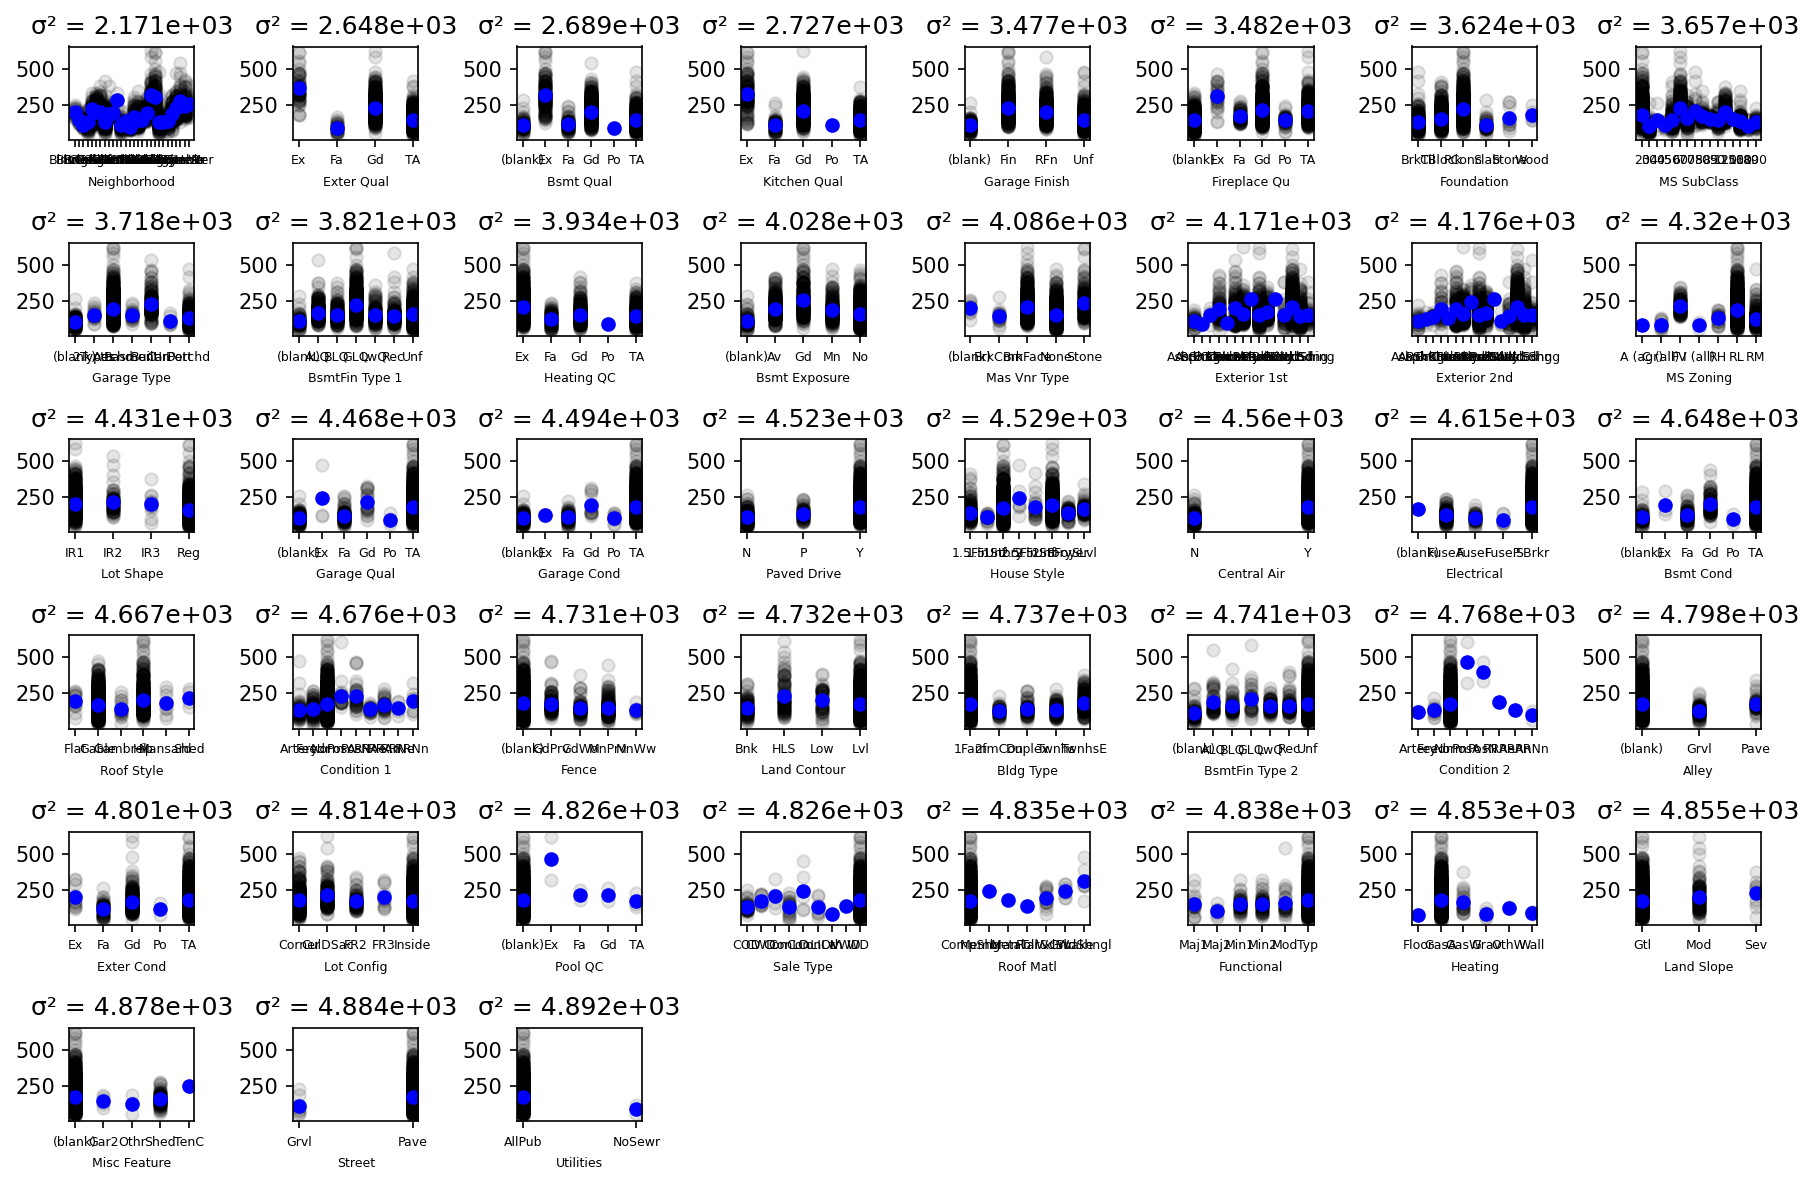

In [85]:
plots = getsubplots(43)
j = 0
for i in sorted_var_dict.keys():
    plots[j].set_xticks(np.arange(len(categorynames[i])))#positions = array of categories
    plots[j].set_xticklabels(categorynames[i], fontsize=6)
    plots[j].scatter(X[:,i], X[:,78], color='black',alpha=0.1)
    num_of_cat = np.size(categorynames[i]) #gets number of categories
    m = meanoff(num_of_cat,i)
    plots[j].scatter(list(range(0,len(m))),m, color='blue')
    plots[j].set_title("σ² = " + str(np.format_float_scientific(int(list(sorted_var_dict.items())[j][1]))))
    plots[j].set_xlabel(featurenames[i],fontsize=6)
    j +=1
    
plt.gcf().tight_layout() 

### Question 2

Now, let's do the same thing, but with the continuous-valued features.  In this case, we will model the distribution of the price, $y$, as a normal distribution whose mean is a linear function of the feature, $x$:

\begin{equation}
p(y\mid x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2\sigma^2}(y - (ax+b))^2}
\end{equation}

Therefore, our parameters are $a$, $b$, and $\sigma^2$.

This is "regular" linear regression and we can use the same equations to fit the data as from the class.

**TO DO**:

Again, make a single figure with a subplots, this time for each continuous-valued feature.

In each subplot, plot a scatter plot of the price versus the feature value, but this time for the continuous-valued features.  On each subplot, in blue plot the regression line ($y = ax+b$).  Again, title the plots by the variance of the estimator and sort from lowest variance (best single-feature estimator) to highest variance.  

As an example, the subplot for the "Year Built" feature should look like

<img src="yearbuiltexample.png">

Hints:
 - Some continuous-valued features having missing values.  These are encoded as `NaN`.  You should omit those examples (from both $y$ and $x$) when calculating the regression coefficients for that feature.  The numpy function `np.isnan(v)` will return a boolean-valued vector that is `True` where `v` is `NaN` and `False` elsewhere.
 - Some continuous-valued features do not have any variation (perhaps not for this part, but for later questions).  That is, $x$ is a constant.  This makes it impossible to estimate a slope.  Set $a=0$ and just let $b$ be the mean $y$ value.
 - If there are no points at all left after removing `NaN`s, then there isn't really a regression problem.  Just let $a=0$ and $b=0$.

In [86]:
con_data = np.where(np.array(iscat) == False) #returns continuous feature numbers
np.shape(con_data)
con_index = con_data[0]
con_index = con_index[: -1]
print(con_index)#indecies of continous features

[ 2  3 16 17 18 19 25 33 35 36 37 42 43 44 45 46 47 48 49 50 51 53 55 58
 60 61 65 66 67 68 69 70 74 75 76]


In [87]:
import pandas as pd
con_var = []
for i in con_index:
    dfxx = pd.DataFrame(X[:,i])
    dfyy = pd.DataFrame(X[:,78])
    frames = [dfxx, dfyy]
    result = pd.concat(frames,axis=1)
    result = result.dropna() #drops all null values
    dfx = pd.DataFrame(result.iloc[:, 0])
    dfy = pd.DataFrame(result.iloc[:, 1])
    A = dfx.values.sum()/2412 #Σx / m
    B = dfy.values.sum()/2412 #Σy / m
    D = dfx-A #x - Σx / m
    C = dfy - B #y - #Σy / m
    multxy = D * C #(x - Σx / m)(y - #Σy / m)
    E = multxy.values.sum() #Σ(x - Σx / m)(y - #Σy / m)
    xsquare = D**2 #(x - Σx / m)**2
    F = xsquare.values.sum() #Σ(x - Σx / m)**2
    a = E/F #Σ(x - Σx / m)(y - #Σy / m) / #Σ(x - Σx / m)**2
    b = B - a*A #Σy / m - a*(Σx / m)
    ax = dfx*a
    temp = (dfy-ax-b)**2 
    var_sum = temp.values.sum()
    var = var_sum/dfy.size #Σ(y-ax-b)**2
    con_var.append(var)
print(con_var)

[4725.150570402434, 4530.348326169906, 1843.6919810621812, 4855.878721207931, 3481.438875175767, 3639.8914273552655, 3791.398994485434, 3894.96522816942, 4891.030814825463, 4776.200048952503, 2885.4051241316342, 2935.7263255019197, 4498.649225701078, 4895.584192617435, 2277.4861094193834, 4470.419044583211, 4887.012982924285, 3427.777628640377, 4480.444505029787, 4737.534496731523, 4833.701881472885, 3694.159872608878, 3706.127208326333, 4613.968188803765, 2918.678265115574, 2986.4452397386476, 4306.010356799229, 4362.756638347548, 4830.164586453867, 4897.497464039976, 4829.168048920535, 4892.3583764084915, 4897.506058963021, 4898.521503608298, 4895.73263206027]


In [88]:
unsorted_cat_d = dict(zip(con_index,con_var))
con_sorted_d = dict(sorted(unsorted_cat_d.items(), key=lambda item: item[1]))#sorting by variance
print(con_sorted_d) 

{16: 1843.6919810621812, 45: 2277.4861094193834, 37: 2885.4051241316342, 60: 2918.678265115574, 42: 2935.7263255019197, 61: 2986.4452397386476, 48: 3427.777628640377, 18: 3481.438875175767, 19: 3639.8914273552655, 53: 3694.159872608878, 55: 3706.127208326333, 25: 3791.398994485434, 33: 3894.96522816942, 65: 4306.010356799229, 66: 4362.756638347548, 46: 4470.419044583211, 49: 4480.444505029787, 43: 4498.649225701078, 3: 4530.348326169906, 58: 4613.968188803765, 2: 4725.150570402434, 50: 4737.534496731523, 36: 4776.200048952503, 69: 4829.168048920535, 67: 4830.164586453867, 51: 4833.701881472885, 17: 4855.878721207931, 47: 4887.012982924285, 35: 4891.030814825463, 70: 4892.3583764084915, 44: 4895.584192617435, 76: 4895.73263206027, 68: 4897.497464039976, 74: 4897.506058963021, 75: 4898.521503608298}


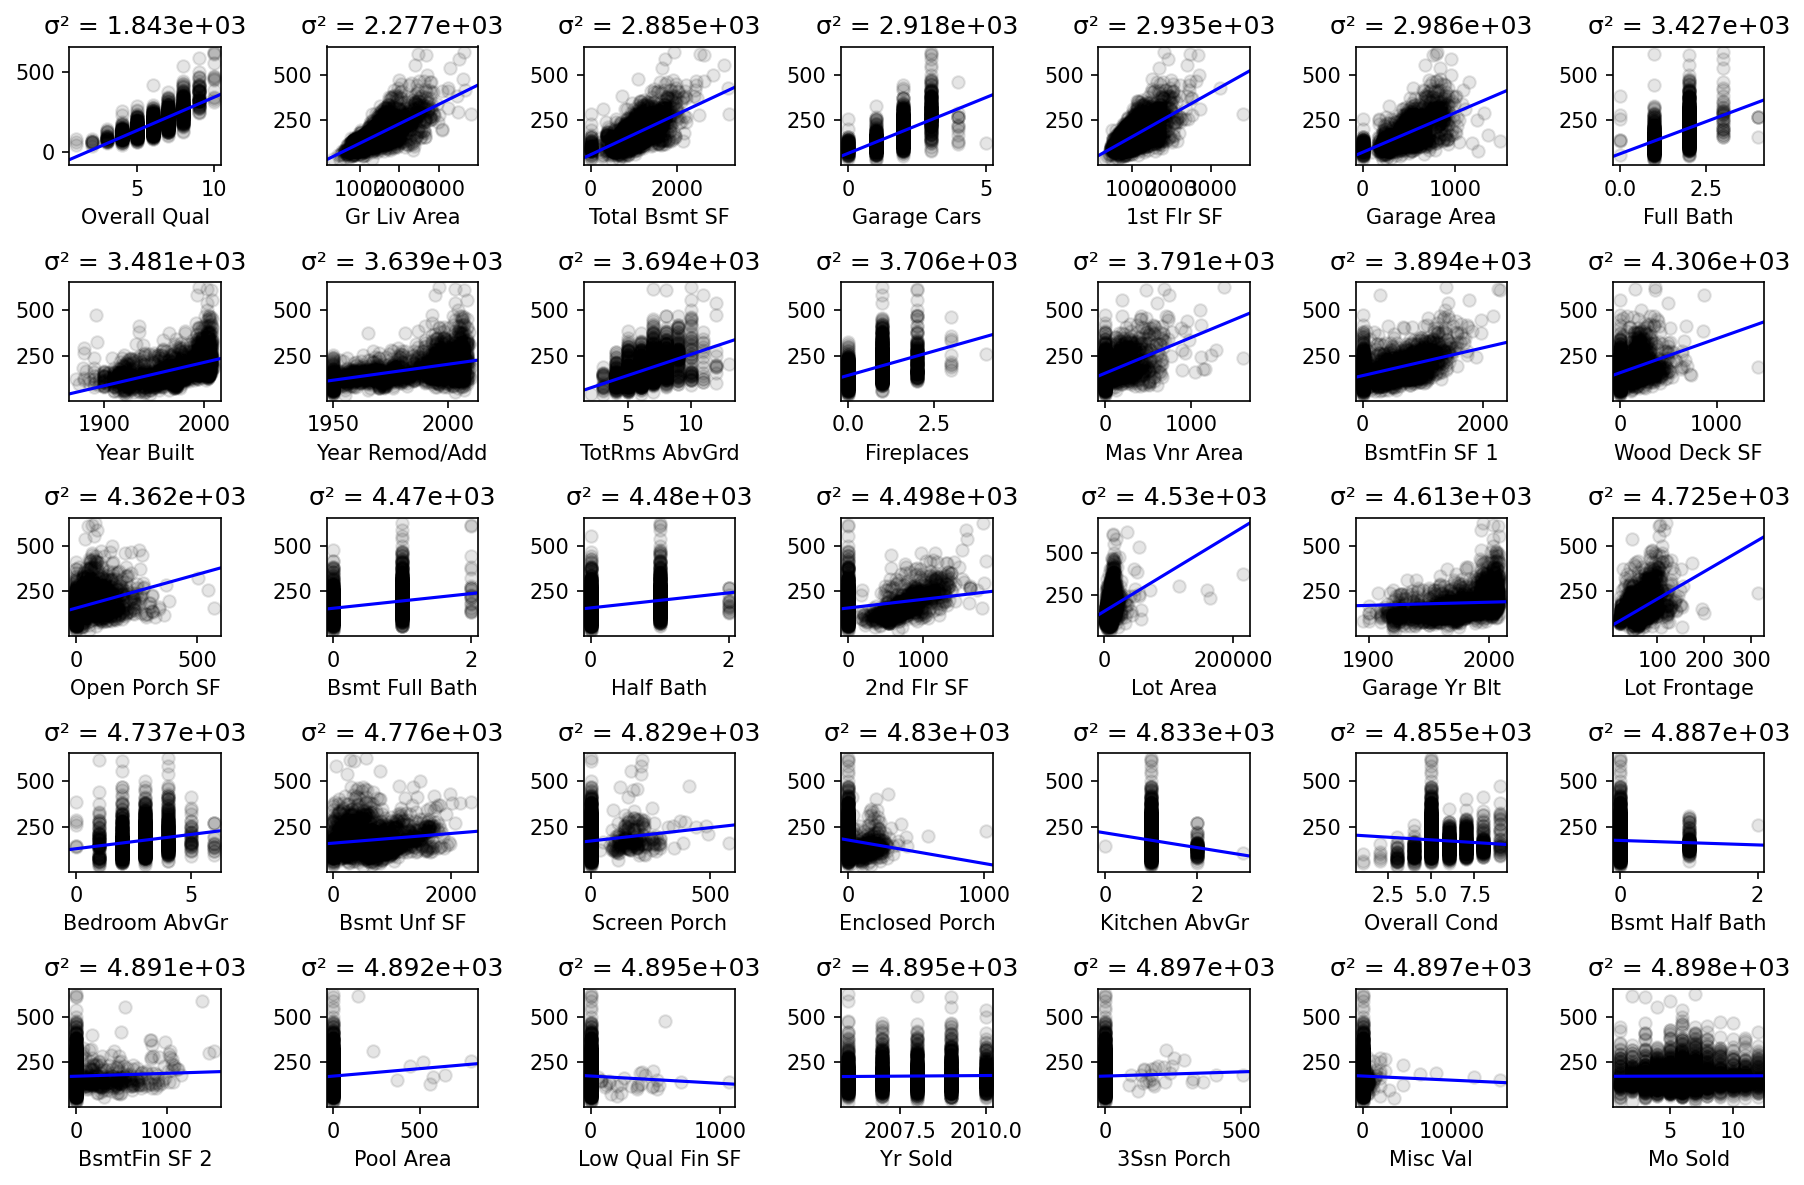

In [ ]:
j = 0
plots = getsubplots(35)
varval = []
for i in con_sorted_d.keys():
    dfx1 = pd.DataFrame(X[:,i])
    dfy1 = pd.DataFrame(X[:,78])
    frames = [dfx1, dfy1]
    result = pd.concat(frames,axis=1)
    result = result.dropna()
    dfx = pd.DataFrame(result.iloc[:, 0])
    dfy = pd.DataFrame(result.iloc[:, 1])
    A = dfx.values.sum()/2412
    B = dfy.values.sum()/2412
    D = dfx-A
    C = dfy - B
    multxy = D * C
    E = multxy.values.sum()
    xsquare = D**2
    F = xsquare.values.sum()
    a = E/F
    b = B - a*A
    ax = dfx*a
    temp = (dfy-ax-b)**2
    var_sum = temp.values.sum()
    var = var_sum/dfy.size
    con_var.append(var)
    plots[j].scatter(X[:,i], X[:,78],color = 'black', alpha = 0.1)
    plots[j].set_title("σ² = " + str(np.format_float_scientific(int(list(con_sorted_d.items())[j][1]))))
    plots[j].set_xlabel(featurenames[i])
    plotline(plots[j],a,b)
    j +=1
    #for question 4
    if(i==51):
        a51 = a
        b51 = b
plt.gcf().tight_layout()